## Barcelona .csv files:

The Barca open data set linked below contains lots of interesting stuff to explore. As I keep playing with this I'm realizing that the many bits of learning are getting jumbled and need some new structure. This notebook is just focused on how to import, filter, and plot a .csv file (the Barca street data specifically). Reading and plotting .shp files and .geojson files are in separate notebooks.

[BCN Open Data (Trams - carrer):](https://opendata-ajuntament.barcelona.cat/data/en/dataset/mapa-graf-viari-carrers-wms)

[Geopandas Reference:](https://geopandas.org/en/stable/index.html)

[Barca Street Mapping:](https://diegoquintanav.github.io/folium-barcelona-EN.html) This github  page describes taking .csv data and transforming that point data into Shapely LineStrings that can be plotted. Along the way I am clearly going to develop some experience with manipulating pandas data frames:)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import geoplot as gp
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from IPython.display import display, Image
from shapely.geometry import Point, LineString

### Reading the .csv data:

Pandas originally had difficulty decoding some of the characters. When I opened the .csv file in Libre these characters may be the ones that showed as unreadable. Resaving the file from Libre and reading it in embeds these error characters with no issues. Interesting data science question I suspect. 

#### Encoding Issues:

As I got deeper into this project I found there were a lot of encoding errors that made searching and labeling frustrating. After some thought I went back and reopened the original trams.csv file using 'Latin 3' encoding and Catalan as the language. This seemed to produce a file with no obvious errors in reading cells. Then there was a problem using pd.read_csv which uses a utf-8 default encoding. This question came up on [a stackexchange post](https://datascience.stackexchange.com/questions/12343/pandas-read-csv-with-spanish-characters)  and a suggestion that seemed consistent was to define the pandas read_csv edcoding as 'latin-1' (I tried 'latin-3' to match the orginal file read encoding in Libre office but that doesn't exist). Using this encoding made pandas happy -- we'll see if it resolves most of the issues. 

[List of Encodings;](https://docs.python.org/3/library/codecs.html#standard-encodings)

So -- the above steps resolved (I think) the encoding issues for the street names in the .csv file but they introduced some unpredicatable errors in the encoding for the coordinates. This led to unplotable points on the street lines that were produced. Now I need to figure out if I can manage the encoding for numbers separately from characters or encode single columns.

**Current Status:** If I open the .csv file with 'latin 3' character set and English encodings it seems that it doesn't screw up the coordinates and reads the street names well enough. Because I can't type the 'latin' characters there are some limitations to my ability to manually slice the data frame but pershaps that won't be a problem.

In [2]:
streets = pd.read_csv("bcn-geodata/BCN_GrafVial_CSV/BCN_Trams2.csv", sep=",", encoding='latin-1')
streets.head(10)

,FID,COORD_X,COORD_Y,LONGITUD,ANGLE,C_Tram,C_Nus_I,C_Nus_F,Distric_D,NDistric_D,...,TVia_D,NVia_D,Tram_Dret,Distric_E,NDistric_E,Illa_E,CVia_E,TVia_E,NVia_E,Tram_Esq
0,0,432128.893,4581047.606,42.615,15.04,T00001B,N00001D,N00002E,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,2,1,Ciutat Vella,10410,10900,Carrer,Carrer Pepe Rubianes,1
1,1,432156.649,4581054.946,14.806,14.20,T00002C,N00002E,N00003F,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5
2,2,432171.171,4581059.200,15.480,18.40,T00003D,N00003F,N00004G,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5
3,3,432185.863,4581063.068,14.969,10.98,T00004E,N00004G,N00005H,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,8 <=> 8 Z,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9
4,4,432200.396,4581066.659,15.010,16.80,T00005F,N00005H,N00006I,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,10,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9
5,5,432214.836,4581070.635,14.953,14.00,T00006G,N00006I,N00007J,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,12 <=> 14,1,Ciutat Vella,10461,10900,Carrer,Carrer Pepe Rubianes,11 <=> 13
6,6,432229.274,4581074.508,14.949,16.00,T00007H,N00007J,N00008K,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,12 <=> 14,1,Ciutat Vella,10461,10900,Carrer,Carrer Pepe Rubianes,11 <=> 13
7,7,432243.459,4581078.413,14.477,14.70,T00008I,N00008K,N00009L,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,16,1,Ciutat Vella,10480,10900,Carrer,Carrer Pepe Rubianes,15 - 17
8,8,432257.772,4581082.416,15.252,16.50,T00009J,N00009L,N00010E,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,18,1,Ciutat Vella,10480,10900,Carrer,Carrer Pepe Rubianes,15 - 17
9,9,432272.244,4581086.671,14.916,16.30,T00010C,N00010E,N00011F,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,20,1,Ciutat Vella,10490,10900,Carrer,Carrer Pepe Rubianes,19 - 21


### From Pandas to Geopandas

The .csv file is read in as a pandas data frame. For mapping purposes it needs to be converted to a geopandas data frame which basically involves reading the x and y coordinate columns and converting them to shapely Points in a colum named geometry. The new columm is at the end of the data frame.

In [4]:
tramsFull = gpd.GeoDataFrame(streets, geometry = gpd.points_from_xy(streets.COORD_X,streets.COORD_Y))
tramsFull

,FID,COORD_X,COORD_Y,LONGITUD,ANGLE,C_Tram,C_Nus_I,C_Nus_F,Distric_D,NDistric_D,...,NVia_D,Tram_Dret,Distric_E,NDistric_E,Illa_E,CVia_E,TVia_E,NVia_E,Tram_Esq,geometry
0,0,432128.893,4581047.606,42.615,15.04,T00001B,N00001D,N00002E,1,Ciutat Vella,...,Carrer Pepe Rubianes,2,1,Ciutat Vella,10410,10900,Carrer,Carrer Pepe Rubianes,1,POINT (432128.893 4581047.606)
1,1,432156.649,4581054.946,14.806,14.20,T00002C,N00002E,N00003F,1,Ciutat Vella,...,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5,POINT (432156.649 4581054.946)
2,2,432171.171,4581059.200,15.480,18.40,T00003D,N00003F,N00004G,1,Ciutat Vella,...,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5,POINT (432171.171 4581059.200)
3,3,432185.863,4581063.068,14.969,10.98,T00004E,N00004G,N00005H,1,Ciutat Vella,...,Carrer Pepe Rubianes,8 <=> 8 Z,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9,POINT (432185.863 4581063.068)
4,4,432200.396,4581066.659,15.010,16.80,T00005F,N00005H,N00006I,1,Ciutat Vella,...,Carrer Pepe Rubianes,10,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9,POINT (432200.396 4581066.659)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14826,14826,426840.231,4583372.122,37.131,306.71,T21653T,N07106N,N10755R,5,Sarrià-Sant Gervasi,...,Via Augusta,313,5,Sarrià-Sant Gervasi,34491,28000,Via,Via Augusta,313,POINT (426840.231 4583372.122)
14827,14827,426952.780,4583228.384,133.414,312.34,T21654U,N10463I,N10519H,5,Sarrià-Sant Gervasi,...,Carrer Cardenal Sentmenat,2 - 6,5,Sarrià-Sant Gervasi,34421,65301,Carrer,Carrer Cardenal Sentmenat,1 - 5,POINT (426952.780 4583228.384)
14828,14828,433594.464,4583025.419,119.651,314.89,T21656W,N11406D,N08604E,10,Sant Martí,...,Carrer Llacuna,2,10,Sant Martí,5989,183603,Carrer,Carrer Llacuna,1,POINT (433594.464 4583025.419)
14829,14829,433492.108,4582841.885,404.104,45.14,T21657X,N08591Q,N11406D,10,Sant Martí,...,,0,10,Sant Martí,5989,700662,Carrer,Carrer Salvador Espriu,97 <=> 99 - 109,POINT (433492.108 4582841.885)


### Plot the Points:

Because I suspect that these data points are much the same as the .shp file data I'm going to plot this data frame and see if it looks the same. 

Analysis: After plotting this data set seems much the same as the .shp data file with more density of data. Not sure how that will cross things up but we'll see. 

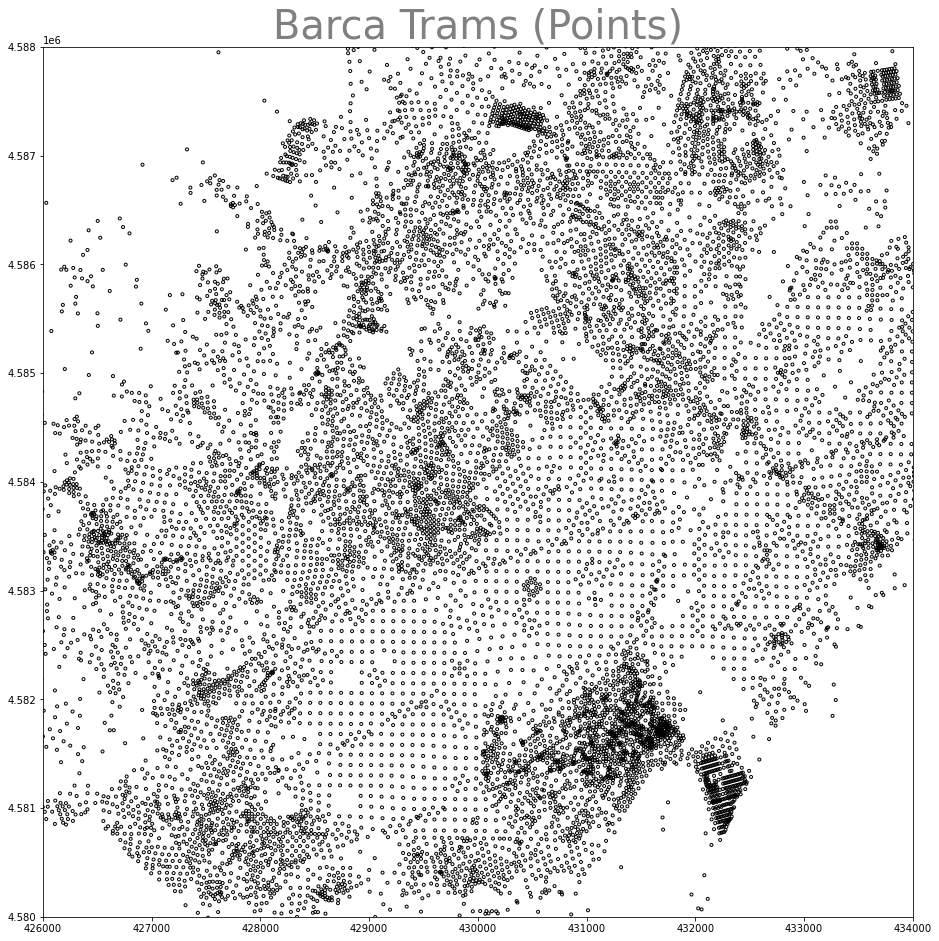

In [5]:
fig, ax = plt.subplots(figsize=(16,16))

fc1 = colorConverter.to_rgba('green', alpha=0.2)

tramsFull.plot(ax=ax, facecolor = 'none', edgecolor = 'k', marker = '.') 


plt.title("Barca Trams (Points)", fontsize=40, color='grey')
plt.xlim(426000, 434000)
plt.ylim(4580000, 4588000)
#plt.axis('equal')

plt.show()

### Next Steps:

Now that I have read the file and converted it to Points that can be managed and plotted by geopandas it's time to ask how to turn these points into liines which represent the streets (carrer/placa/avinguda)